<a href="https://colab.research.google.com/github/indira-sm/MAT1856-Assignment1/blob/main/Indira_APM466.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from numpy import linalg as LA
import plotly.graph_objects as go
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Bond Data


In [3]:
prices = ((99.63,99.64,99.65,99.661,99.67,99.687,99.68,99.683,99.708,99.72),
(97.96, 97.98,97.985,97.982,98.021,98.054,97.974,97.975,97.999, 98.007),
(96.46,96.482,96.552,96.576,96.661,96.715,96.54,96.448,96.495,96.46),
(94.34,94.37,94.38,94.43,94.49,94.49,94.42,94.25,94.24,94.22),
(92.862,92.86,92.844,92.856,93.023,93.008,92.796,92.57,92.546,92.545),
(93.46,93.44,93.55,93.53,93.6,93.57,93.4,93.12,93.08,93.07),
(93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764),
(97.58,97.591,97.603,97.52,97.74,97.772,97.441,97.092,96.956,96.947),
(100.5,100.48,100.439,100.328,100.637,100.673,100.22,99.834,99.662,99.623),
(99.74,99.72,99.72,99.55,99.88,99.91,99.44,98.99,98.81,98.77))
maturities = (dt.datetime(2024,3,1),dt.datetime(2024,9,1),
              dt.datetime(2025,3,1),dt.datetime(2025,9,1),
              dt.datetime(2026,3,1),dt.datetime(2026,9,1),
              dt.datetime(2027,3,1),dt.datetime(2027,9,1),
              dt.datetime(2028,3,1),dt.datetime(2028,9,1))
coupons = (2.25,1.50,1.25,0.50,0.25,1.00,1.25,2.75,3.50,3.25)

bonds = []
start_day = dt.datetime(2024,1,8)
for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = start_day + dt.timedelta(days=add[i])
  bond = []
  for j in range(10):
    bond.append((prices[j][i], coupons[j],round(((maturities[j]-day).days)/365,3)))
  bonds.append(bond)

## Calculate Yield Curve

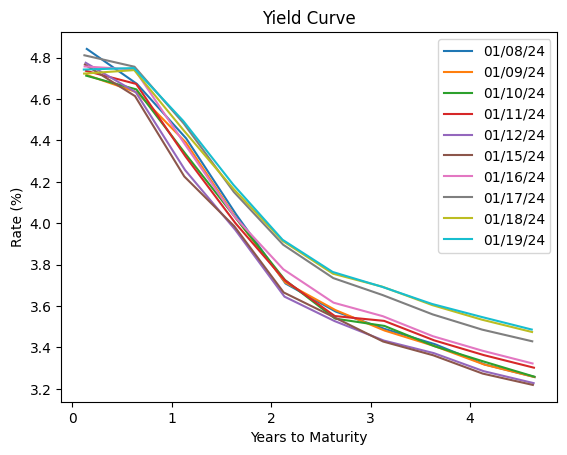

In [4]:
def dirty_price(bond,date):
  time_since_last_payment = (date-dt.datetime(2023,9,1)).days
  dirty_price = (bond[0])+round((time_since_last_payment/365),2)*bond[1]


  return dirty_price


def yield_curve(bonds,date):
  rates = []

  for i in range(10):
    six_month_coupon = (bonds[i][1])/2
    rate = dirty_price(bonds[i],date)

    for j in range(i):
      rate = rate - (six_month_coupon)*(np.exp(-1*rates[j]*bonds[j][2]))
    rate = (np.log(rate/(100+six_month_coupon)))/(-1*bonds[i][2])
    rates.append(rate)
  return rates


for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = dt.datetime(2024,1,8) + dt.timedelta(days=add[i])
  X = []
  for j in range(10):
    X.append(bonds[i][j][2])
  Y = np.multiply(yield_curve(bonds[i],day),100)
  plt.plot(X,Y, label = day.strftime('%x'))

plt.xlabel('Years to Maturity')
plt.ylabel('Rate (%)')
plt.title('Yield Curve')
plt.legend()

## Calculate Spot Rate Curve

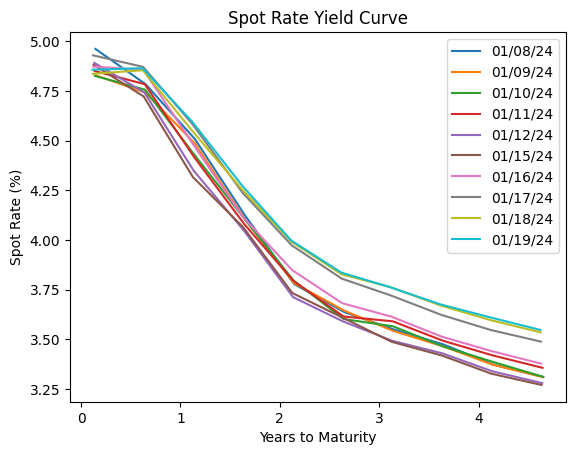

In [5]:
def spot_rate(bonds,date):
  rates = []

  for i in range(10):
    six_month_coupon = (bonds[i][1])/2
    payments = 1
    if i == 0:
      payments = 0
    rate = dirty_price(bonds[i],date)
    for j in range(i):
      rate = rate - (six_month_coupon)/((1+rates[j])**(bonds[j][2]))
    rate = (((100+(six_month_coupon))/rate)**(1/bonds[i][2]))-1
    rates.append(rate)
  return rates


for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = dt.datetime(2024,1,8) + dt.timedelta(days=add[i])
  X = []
  for j in range(10):
    X.append(bonds[i][j][2])
  Y = np.multiply(spot_rate(bonds[i],day),100)
  plt.plot(X,Y, label = day.strftime('%x'))

plt.xlabel('Years to Maturity')
plt.ylabel('Spot Rate (%)')
plt.title('Spot Rate Yield Curve')
plt.legend()

## Calulate Forward Rates

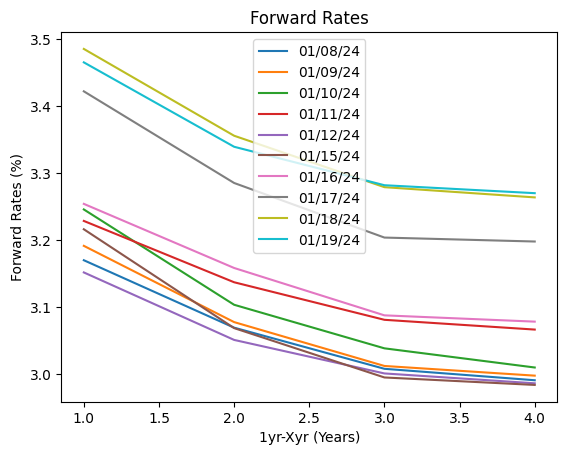

In [6]:
def forward_rates(bonds,day):
  spot_rates = spot_rate(bonds,day)

  interpolated_spots = []
  forward_rates = []
  for i in [1,2,3,4]:
    j = 0
    while bonds[j][2] < (i):
      before= bonds[j][2]
      spot_before = spot_rates[j]
      j = j+1
    after = bonds[j][2]
    spot_after = spot_rates[j]
    spot = (spot_before*(after-i) + spot_after*(i-before))/(after-before)
    interpolated_spots.append(spot)
  interpolated_spots.append(spot_rates[9])

  for i in [1,2,3,4]:
    forward_rates.append((((i+1)*interpolated_spots[i])-interpolated_spots[0])/(i))
  return forward_rates



for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = dt.datetime(2024,1,8) + dt.timedelta(days=add[i])
  X = [1,2,3,4]
  Y = np.multiply(forward_rates(bonds[i],day),100)
  plt.plot(X,Y, label = day.strftime('%x'))


plt.xlabel('1yr-Xyr (Years)')
plt.ylabel('Forward Rates (%)')
plt.title('Forward Rates')
plt.legend()


## Calculate Covariance Matrices and Principal Eigenspectrum

In [11]:
def log_returns(rates):
  Xi = []
  for i in range(4):
    Xij = []
    for j in range(9):
      Xij.append(np.log(rates[j+1][i]/rates[j][i]))
    Xi.append(Xij)
  return Xi

yields = []
for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = dt.datetime(2024,1,8) + dt.timedelta(days=add[i])
  yields.append(yield_curve(bonds[i],day))

yield_log_returns = log_returns(yields)

forwards = []
for i in range(10):
  add = (0,1,2,3,4,7,8,9,10,11)
  day = dt.datetime(2024,1,8) + dt.timedelta(days=add[i])
  forwards.append(forward_rates(bonds[i],day))

forward_log_returns = log_returns(forwards)

yield_cov = np.cov(yield_log_returns)
forward_cov = np.cov(forward_log_returns)

print('yield rate covariance matrix:')
print(forward_cov)
print('forward rate covariance matrix:')
print(forward_cov)

yield_eigenvalues, yield_eigenvectors = LA.eig(yield_cov)
forward_eigenvalues, forward_eigenvectors = LA.eig(forward_cov)


print("yield_eigenvalues\n",np.transpose(yield_eigenvalues), '\nyield_eigenvectors\n',yield_eigenvectors)
print("forward_eigenvalues\n",forward_eigenvalues, '\nforward_eigenvectors\n',forward_eigenvectors)


yield rate covariance matrix:
[[0.00043737 0.00034832 0.00030544 0.00029558]
 [0.00034832 0.00038263 0.00036813 0.00036918]
 [0.00030544 0.00036813 0.00036857 0.0003697 ]
 [0.00029558 0.00036918 0.0003697  0.00037788]]
forward rate covariance matrix:
[[0.00043737 0.00034832 0.00030544 0.00029558]
 [0.00034832 0.00038263 0.00036813 0.00036918]
 [0.00030544 0.00036813 0.00036857 0.0003697 ]
 [0.00029558 0.00036918 0.0003697  0.00037788]]
yield_eigenvalues
 [4.77700374e-04 1.41060922e-04 1.54466164e-05 7.07675503e-05] 
yield_eigenvectors
 [[ 0.21523847  0.96123236  0.11887959 -0.12478943]
 [ 0.42098951 -0.09260095 -0.65970079 -0.61561982]
 [ 0.78324989 -0.25023388  0.56802052 -0.03543047]
 [ 0.40368285  0.06957318 -0.47750938  0.77729307]]
forward_eigenvalues
 [1.42043242e-03 1.40214608e-04 2.78706987e-06 3.01916614e-06] 
forward_eigenvectors
 [[ 0.48739081 -0.8436828   0.20103586  0.10116379]
 [ 0.5170642   0.07712237 -0.82811486 -0.20229317]
 [ 0.49740861  0.32972977  0.49546649 -0.6311